# Montagem da Rede

In [1]:
import pathlib
import pickle
import cpnet
import netpixi
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from netpixi.integration.gt import *
from regression.integration.gt import *
from graph_tool import spectral

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


## Leitura dos Dados Pré-Processados

In [2]:
DATA_DIR = pathlib.Path.cwd().parent / 'projeto' / 'data'
print(DATA_DIR)

/home/jupyter/notebooks/projeto/data


In [3]:
PROCESSED_FILE_PATH = DATA_DIR / 'processed' / 'enem_sampled.pkl'

In [4]:
print(PROCESSED_FILE_PATH)

/home/jupyter/notebooks/projeto/data/processed/enem_sampled.pkl


In [5]:
with open(PROCESSED_FILE_PATH, 'rb') as file:
    (
        data
    ) = pickle.load(file)


In [6]:
sampled_data = data.sample(1500)

Resetando os índices para facilitar identificação após montagem da rede

In [7]:
df = sampled_data.reset_index()

In [8]:
print(df.shape)
df.head(5)

(1500, 31)


,index,NU_INSCRICAO,TP_FAIXA_ETARIA,TP_SEXO,Q001,Q002,Q005,Q006,Q007,Q008,...,Q024,RESPOSTAS_PROVA,GABARITO_OFICIAL,Q005_str,RESPOSTAS_QUESTIONARIO,ACERTOS_TOTAIS,RESPOSTAS_ESPECIFICAS,RESPOSTAS_GERAIS,ACERTOS_GERAIS,ACERTOS_ESPECIFICAS
0,2146868,210054238796,11,M,E,C,2.0,C,A,B,...,B,DCBECBBAAEBBCADAEBDCABDACDBABCDDDAACEBAEDBDAEC...,DCEADABDACDCEABDDADBEDDDEBBACCDDDCCEBBBBEBAAEA...,B,BECCABCAABAAAAABCB,60,AAACBCBDBAABEDBCECEBBACBDCABCBABDEBCADBBCCAEEA...,DCBECBBAAEBBCADEBDCABDCDBABCDDDAEBAEDDAEBEAAAB...,32,28
1,2822966,210052121926,3,F,B,B,8.0,D,A,D,...,C,DEEACCDDAEEBEAEAADCCDCDDBDBABCECDDABBCDEDECBAA...,DCEADABDACDCEABDDADBEDDDEBBACCDDDCCEBBBBEBAAEA...,E,EBBDADEAACCBBAACEC,51,ADDBEABACABBAEDBDCABEAEDCCCDDBEEAEDBDCEEEBBCAC...,DEEACCDDAEEBEAEADCCDCDBDBABCECDABCDEDCBACEAEAB...,30,21
2,2965833,210054081240,6,F,G,F,4.0,H,A,C,...,D,EEDBCAADADDBEABDDAEBDADAABDABCDCAACBABDAECAAAA...,DCEADABDACDCEABDDADBEDDDEBBACCDDDCCEBBBBEBAAEA...,D,DGFHACDABBBBBBABED,93,DAABCACEBEBBEECAEBEBBAEBAAABDEBDBECDACABEEAECC...,EEDBCAADADDBEABDAEBDADABDABCDCACABDAEAAABCABAB...,44,49
3,2322664,210051351311,10,M,D,F,5.0,G,A,B,...,B,DEEACCEBEAACBEDBBEADADDCCBDEACCEDABCDDDAEEBBAA...,DCEADABDACDCEABDDADBEDDDEBBACCDDDCCEBBBBEBAAEA...,E,EDFGABDBCBABABAAEB,55,BCACEACEADCBADCBBDCAEBDABEDBDBACBECCBAABEABEAB...,DEEACCEBEAACBEDBEADADDCBDEACCEDBDDDAEBBADDBAEE...,20,35
4,2660396,210054361898,17,F,A,B,2.0,B,A,B,...,A,ECBADDABAABAEBDDCDDAABADEDCECADBBEAABCEEDABCAA...,DCEADABDACDCEABDDADBEDDDEBBACCDDDCCEBBBBEBAAEA...,B,BABBABCAABAAAAABCA,55,DDEAAAECCDBCECDDDEEBBCEABDADAEEDBBECDDABEAAADD...,ECBADDABAABAEBDCDDAABAEDCECADBBABCEEDBCABCAAAB...,26,29


## Montagem de Rede de Questionário Socioeconômico

In [9]:
n_candidatos = df.shape[0]
n_perguntas_questionario = len(df['RESPOSTAS_QUESTIONARIO'].iloc[0])
n_candidatos, n_perguntas_questionario

(1500, 18)

In [10]:
respostas_questionario = df['RESPOSTAS_QUESTIONARIO'].tolist()

Antes de montar a rede por si só, precisamos dar uma olhada nos dados para ver qual a quantidade de perguntas respondidas em comum para que uma aresta possa ser formada

In [11]:
respostas_iguais_quest = list()
for id_prova1 in range(n_candidatos):
    for id_prova2 in range(id_prova1 + 1, n_candidatos):
        n_respostas_iguais = 0
        for i in range(n_perguntas_questionario):
            if (respostas_questionario[id_prova1][i] == respostas_questionario[id_prova2][i]):
                n_respostas_iguais+=1
        respostas_iguais_quest.append(n_respostas_iguais)

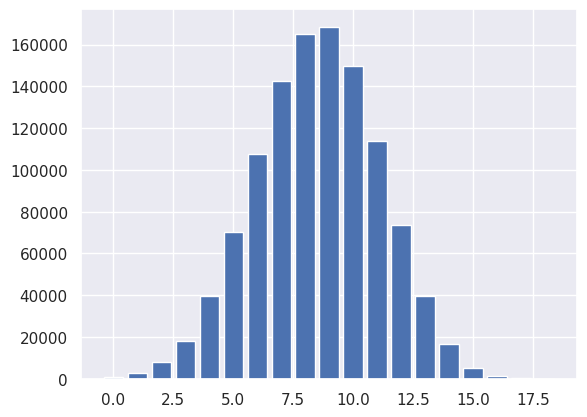

In [12]:
freq_questionario = Counter(respostas_iguais_quest)
plt.figure()
plt.bar(freq_questionario.keys(), freq_questionario.values())
plt.show()

In [13]:
np.mean(respostas_iguais_quest)

8.497057593951522

In [14]:
np.median(respostas_iguais_quest)

9.0

Como esse gráfico se assemelha bastante com uma normal, vamos tentar utilizar a média ~= mediana como threshold de criação de aresta. Contudo, também pode ser interessante usar um threshold mais restritivo, por isso vamos usar o 3° quartil para tanto.

In [15]:
def define_arestas(respostas, threshold):
    arestas = list()
    n_candidatos = len(respostas)
    n_perguntas = len(respostas[0])
    for candidato1 in range(n_candidatos):
        for candidato2 in range(candidato1 + 1, n_candidatos):
            n_respostas_iguais = 0
            for pergunta in range(n_perguntas):
                if (respostas[candidato1][pergunta] == respostas[candidato2][pergunta]):
                    n_respostas_iguais += 1
            if n_respostas_iguais >= threshold:
                arestas.append((candidato1, candidato2))
    return arestas

In [16]:
arestas_questionario_mean = define_arestas(respostas_questionario, np.mean(respostas_iguais_quest))

In [17]:
arestas_questionario_restrict = define_arestas(respostas_questionario, np.quantile(respostas_iguais_quest, 0.75))

In [18]:
def cria_grafo_nao_dirigido(arestas):
    g = Graph(directed=False)
    for aresta in arestas:
        if not(g.has_vertex(aresta[0])):
            g.add_vertex(aresta[0])
        if not(g.has_vertex(aresta[1])):
            g.add_vertex(aresta[1])
        if not (g.has_edge(aresta[0], aresta[1])):
            g.add_edge(aresta[0], aresta[1])
    return g

In [19]:
g_quest_mean = cria_grafo_nao_dirigido(arestas_questionario_mean)

In [20]:
g_quest_restrict = cria_grafo_nao_dirigido(arestas_questionario_restrict)

Salvando grafo no diretório de resultados

In [21]:
RESULTS_DIR = pathlib.Path.cwd().parent / 'projeto' / 'results1500'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [22]:
GRAFOS_DIR = RESULTS_DIR / 'grafos'
GRAFOS_DIR.mkdir(parents=True, exist_ok=True)

In [23]:
gt_save(g_quest_mean, GRAFOS_DIR / 'g_quest_mean.net.gz')
gt_save(g_quest_restrict, GRAFOS_DIR / 'g_quest_restrict.net.gz')

In [24]:
def estatisticas_grafo_nao_dirigido(g):
    stats = dict()
    n = g.num_vertices()
    m = g.num_edges()
    max_edges = n * (n-1) // 2
    d = m / max_edges
    
    stats['n'] = n
    stats['m'] = m
    stats['max_edges'] = max_edges
    stats['d'] = d
    
    return stats

In [25]:
g_quest_mean_stats = estatisticas_grafo_nao_dirigido(g_quest_mean)
g_quest_restrict_stats = estatisticas_grafo_nao_dirigido(g_quest_restrict)

In [26]:
print(g_quest_mean_stats)

{'n': 1500, 'm': 569015, 'max_edges': 1124250, 'd': 0.5061285301311986}


In [27]:
print(g_quest_restrict_stats)

{'n': 1499, 'm': 400470, 'max_edges': 1122751, 'd': 0.35668638905687905}


In [28]:
def plot_degrees(g):
    data_quest = gt_data(g)
    degrees = []
    for v in g.all_vertices():
        degrees.append(v.total_degree())
    data_quest['degree'] = degrees
    print(data_quest['degree'].describe())
    sns.histplot(data_quest['degree'])

count    1500.000000
mean      758.686667
std       256.861977
min         1.000000
25%       637.000000
50%       818.500000
75%       939.000000
max      1193.000000
Name: degree, dtype: float64


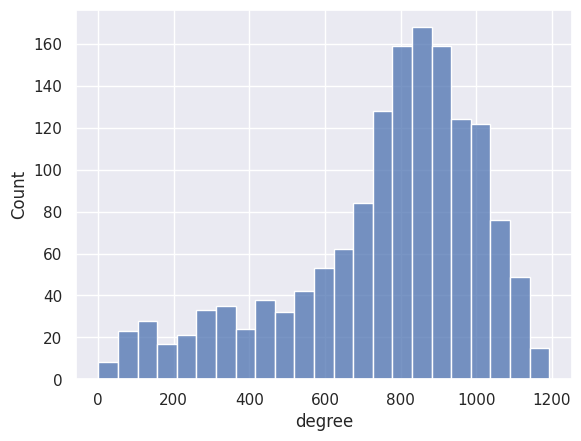

In [29]:
plot_degrees(g_quest_mean)

count    1499.000000
mean      534.316211
std       226.956187
min         4.000000
25%       392.000000
50%       583.000000
75%       705.000000
max       959.000000
Name: degree, dtype: float64


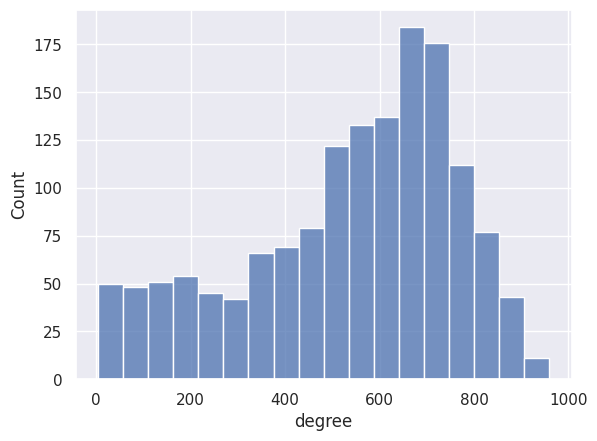

In [30]:
plot_degrees(g_quest_restrict)

In [31]:
def constroi_SFDP(g):
    SFDP_g = gt_clean(g)
    m = gt_draw.sfdp_layout(SFDP_g)
    gt_move(SFDP_g, m)
    return SFDP_g

In [32]:
SFDP_quest_mean = constroi_SFDP(g_quest_mean)
gt_save(SFDP_quest_mean, GRAFOS_DIR / 'SFDP_quest_mean.net.gz')

In [33]:
SFDP_quest_restrict = constroi_SFDP(g_quest_restrict)
gt_save(SFDP_quest_restrict, GRAFOS_DIR / 'SFDP_quest_restrict.net.gz')

In [34]:
# r = netpixi.render('./sample400/SFDP_quest_socioecon.net.gz', infinite=True)

Usando coreness para identificar o "quão de centro" é cada vértice

In [35]:
def measure_coreness(g):
    matrix = spectral.adjacency(g)
    algorithm = cpnet.Rombach()
    algorithm.detect(matrix)
    c = algorithm.get_coreness()
    return c

In [37]:
c_quest_mean = measure_coreness(SFDP_quest_mean)

In [38]:
df['c_quest'] = df.index.map(c_quest_mean.get)

In [39]:
c_quest_restrict = measure_coreness(SFDP_quest_restrict)

In [40]:
df['c_quest_restrict'] = df.index.map(c_quest_restrict.get)

In [41]:
# g_quest_SFDP.add_vp('coreness')
# for i, coreness in c_quest.items():
#     v = g_quest_SFDP.get_vertex_by_index(i)
#     v['coreness'] = float(coreness)

# for v in g_quest_SFDP.all_vertices():
#     r.vertex(v['id'], size=(10 + 40 * v['coreness']))

## Montagem da Rede de Conhecimentos Gerais

In [42]:
respostas_gerais = df['RESPOSTAS_GERAIS'].tolist()

In [43]:
respostas_iguais_prova = list()
n_candidatos = len(respostas_gerais)
n_questoes_gerais = len(respostas_gerais[0])

for id_prova1 in range(n_candidatos):
    for id_prova2 in range(id_prova1 + 1, n_candidatos):
        n_respostas_iguais = 0
        for i in range(n_questoes_gerais):
            if (respostas_gerais[id_prova1][i] == respostas_gerais[id_prova2][i]):
                n_respostas_iguais+=1
        respostas_iguais_prova.append(n_respostas_iguais)

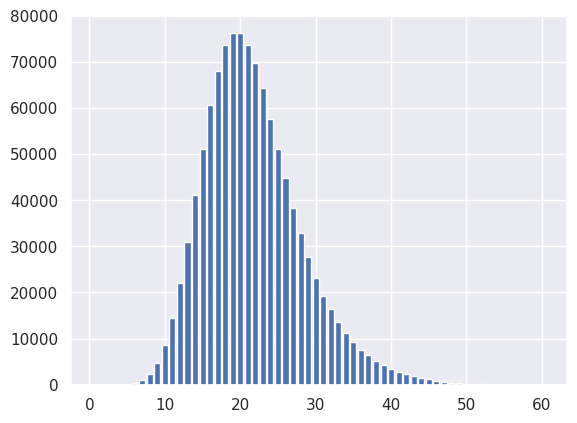

In [44]:
freq_prova = Counter(respostas_iguais_prova)
plt.figure()
plt.bar(freq_prova.keys(), freq_prova.values())
plt.show()

In [45]:
print(f'Média: {np.mean(respostas_iguais_prova)}')
print(f'Mediana: {np.median(respostas_iguais_prova)}')
print(f'Quartis: {np.quantile(respostas_iguais_prova, [0,0.25,0.5,0.75,1])}')

Média: 21.732129864354015
Mediana: 21.0
Quartis: [ 1. 17. 21. 25. 60.]


In [46]:
arestas_prova_mean = define_arestas(respostas_gerais, np.mean(respostas_iguais_prova))

In [47]:
arestas_prova_restrict = define_arestas(respostas_gerais, np.quantile(respostas_iguais_prova, 0.75))

In [48]:
g_prova_mean = cria_grafo_nao_dirigido(arestas_prova_mean)

In [49]:
g_prova_restrict = cria_grafo_nao_dirigido(arestas_prova_restrict)

In [50]:
gt_save(g_prova_mean, GRAFOS_DIR / 'g_prova_mean.net.gz')

In [51]:
gt_save(g_prova_restrict, GRAFOS_DIR / 'g_prova_restrict.net.gz')

In [52]:
g_prova_mean_stats = estatisticas_grafo_nao_dirigido(g_prova_mean)
g_prova_restrict_stats = estatisticas_grafo_nao_dirigido(g_prova_restrict)

In [53]:
print(g_prova_mean_stats)

{'n': 1500, 'm': 518898, 'max_edges': 1124250, 'd': 0.46155036691127416}


In [54]:
print(g_prova_restrict_stats)

{'n': 1496, 'm': 327290, 'max_edges': 1118260, 'd': 0.29267791032496915}


count    1500.000000
mean      691.864000
std       344.975474
min         2.000000
25%       390.750000
50%       809.000000
75%       993.250000
max      1201.000000
Name: degree, dtype: float64


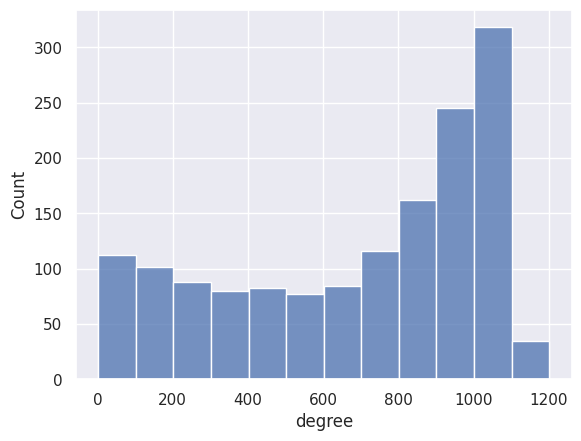

In [55]:
plot_degrees(g_prova_mean)

count    1496.000000
mean      437.553476
std       313.609181
min         1.000000
25%       112.500000
50%       445.000000
75%       746.000000
max       996.000000
Name: degree, dtype: float64


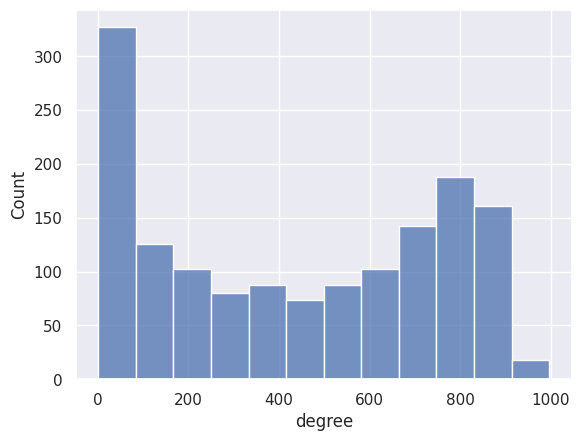

In [56]:
plot_degrees(g_prova_restrict)

In [57]:
SFDP_prova_mean = constroi_SFDP(g_prova_mean)

In [58]:
SFDP_prova_restrict = constroi_SFDP(g_prova_restrict)

In [59]:
gt_save(SFDP_prova_mean, GRAFOS_DIR / 'SFDP_prova_mean.net.gz')

In [61]:
gt_save(SFDP_prova_restrict, GRAFOS_DIR / 'SFDP_prova_restrict.net.gz')

In [62]:
# r = netpixi.render('./sample400/SFPD_grafo_prova.net.gz', infinite=True)

In [63]:
c_prova_mean = measure_coreness(SFDP_prova_mean)

In [64]:
df['c_prova'] = df.index.map(c_prova_mean.get)

In [65]:
c_quest_restrict = measure_coreness(SFDP_quest_restrict)

In [66]:
df['c_prova_restrict'] = df.index.map(c_quest_restrict.get)

In [67]:
# for i, coreness in c_prova.items():
#     v = g_prova_SFDP.get_vertex_by_index(i)
#     v['coreness'] = float(coreness)

# for v in g_prova_SFDP.all_vertices():
#     r.vertex(v['id'], size=(10 + 40 * v['coreness']))

In [68]:
df.head()

,index,NU_INSCRICAO,TP_FAIXA_ETARIA,TP_SEXO,Q001,Q002,Q005,Q006,Q007,Q008,...,RESPOSTAS_QUESTIONARIO,ACERTOS_TOTAIS,RESPOSTAS_ESPECIFICAS,RESPOSTAS_GERAIS,ACERTOS_GERAIS,ACERTOS_ESPECIFICAS,c_quest,c_quest_restrict,c_prova,c_prova_restrict
0,2146868,210054238796,11,M,E,C,2.0,C,A,B,...,BECCABCAABAAAAABCB,60,AAACBCBDBAABEDBCECEBBACBDCABCBABDEBCADBBCCAEEA...,DCBECBBAAEBBCADEBDCABDCDBABCDDDAEBAEDDAEBEAAAB...,32,28,0.859167,0.801667,0.176458,0.822500
1,2822966,210052121926,3,F,B,B,8.0,D,A,D,...,EBBDADEAACCBBAACEC,51,ADDBEABACABBAEDBDCABEAEDCCCDDBEEAEDBDCEEEBBCAC...,DEEACCDDAEEBEAEADCCDCDBDBABCECDABCDEDCBACEAEAB...,30,21,0.165417,0.244162,0.248125,0.813333
2,2965833,210054081240,6,F,G,F,4.0,H,A,C,...,DGFHACDABBBBBBABED,93,DAABCACEBEBBEECAEBEBBAEBAAABDEBDBECDACABEEAECC...,EEDBCAADADDBEABDAEBDADABDABCDCACABDAEAAABCABAB...,44,49,0.807500,0.976667,0.205417,0.906667
3,2322664,210051351311,10,M,D,F,5.0,G,A,B,...,EDFGABDBCBABABAAEB,55,BCACEACEADCBADCBBDCAEBDABEDBDBACBECCBAABEABEAB...,DEEACCEBEAACBEDBEADADDCBDEACCEDBDDDAEBBADDBAEE...,20,35,0.203958,0.180150,0.223333,0.157631
4,2660396,210054361898,17,F,A,B,2.0,B,A,B,...,BABBABCAABAAAAABCA,55,DDEAAAECCDBCECDDDEEBBCEABDADAEEDBBECDDABEAAADD...,ECBADDABAABAEBDCDDAABAEDCECADBBABCEEDBCABCAAAB...,26,29,0.213750,0.236239,0.174792,0.231651


## Exportando arquivos

In [69]:
processed_dir = DATA_DIR / 'processed'
processed_dir.mkdir(parents=True, exist_ok=True)

In [70]:
processed_file_path_centrais = processed_dir / 'candidatos_centrais.pkl'

In [71]:
with open(processed_file_path_centrais, 'wb') as file:
    pickle.dump(df, file)